In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2025-04-17 20:31:25.958801: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 20:31:26.040312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 20:31:26.094658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744918286.132957 4053140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744918286.145258 4053140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 20:31:26.258313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [3]:
env = maze_library.init_environment_python(10,10,5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [4]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [5]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0),
        visited_paths.get(maze_library.Direction.North, False),
        available_paths.get(maze_library.Direction.East, 0),
        visited_paths.get(maze_library.Direction.East, False),
        available_paths.get(maze_library.Direction.South, 0),
        visited_paths.get(maze_library.Direction.South, False),
        available_paths.get(maze_library.Direction.West, 0),
        visited_paths.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0]/10 ,
        state.current_location[1]/10 ,
        state.end_node[0]/10 ,
        state.end_node[1]/10 ,
        info.previous_node[0]/10 ,
        info.previous_node[1]/10 ,
        info.manhattan_distance /10,
        info.goal_dx,
        info.goal_dy,
        info.visited_amount 

    ])

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [19]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])



/home/art/Development/FYP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1744918289.109771 4053140 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
print("Initial Q-values:", model.predict(np.random.rand(1, 19)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Initial Q-values: [[ 0.01270661 -0.38950068 -0.34134015 -0.6171246 ]]


In [8]:
def epsilon_greedy_policy(flat_state, epsilon):
    if np.random.rand() < epsilon:
        # Choose only from valid actions
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(flat_state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


In [9]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [10]:
# def sample_experiences(batch_size):
#     sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
#     half_batch = batch_size // 2

#     # Ensure there are enough samples to choose from
#     num_experiences = len(sorted_experiences)
#     if num_experiences < batch_size:
#         batch = sorted_experiences
#     else:
#         high_priority_samples = sorted_experiences[:half_batch]
#         random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
#         batch = high_priority_samples + random_samples
    
#     return [
#         np.array([experience[field_index] for experience in batch], dtype=np.float32)
#         for field_index in range(6)
#     ]

def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), min(len(replay_buffer), batch_size), replace=False)
    batch = [replay_buffer[i] for i in indices]
    
    return [
        np.array([experience[field_index] for experience in batch], dtype=np.float32)
        for field_index in range(6)
    ]



In [11]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action), 0)
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
highest_reward = -1000000

In [13]:
batch_size = 128
discount_factor = 0.96
q_value_log = []
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
loss_fn = tf.keras.losses.Huber(delta=1.0) # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [14]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 5, eps: 1.000, reward = -27.75
Episode: 100, Steps: 5, eps: 0.963, reward = -29.0
Episode: 200, Steps: 8, eps: 0.926, reward = -21.850000143051147
Episode: 205, Steps: 18, eps: 0.924, reward = 39.74999842047691
Episode: 300, Steps: 26, eps: 0.889, reward = -38.89999979734421
Episode: 340, Steps: 9, eps: 0.874, reward = 54.94999870657921
Episode: 400, Steps: 12, eps: 0.852, reward = -20.099999994039536


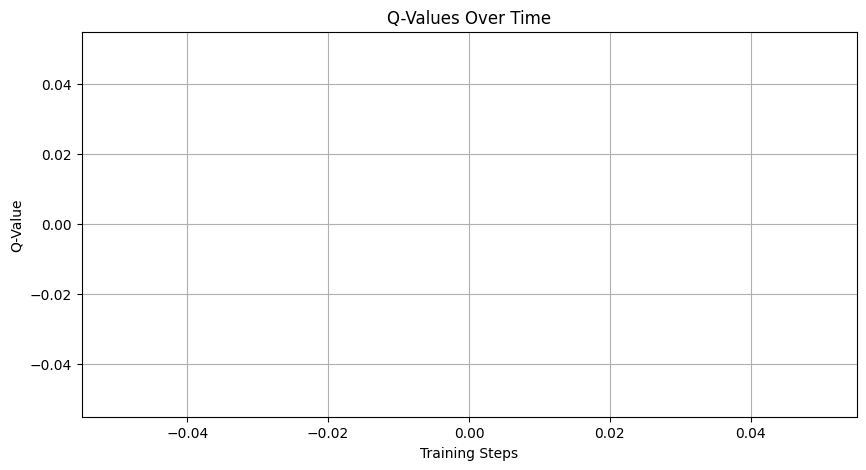

Episode: 500, Steps: 7, eps: 0.815, reward = -22.099999964237213
Episode: 600, Steps: 5, eps: 0.778, reward = -20.550000071525574
Episode: 648, Steps: 8, eps: 0.760, reward = 59.399998515844345
Episode: 687, Steps: 12, eps: 0.746, reward = 52.19999858736992
Episode: 700, Steps: 17, eps: 0.741, reward = -39.300000071525574
Episode: 719, Steps: 12, eps: 0.734, reward = 51.04999876022339
Episode: 772, Steps: 8, eps: 0.714, reward = 57.49999865889549
Episode: 800, Steps: 19, eps: 0.704, reward = -17.90000006556511
Episode: 900, Steps: 5, eps: 0.667, reward = -29.75


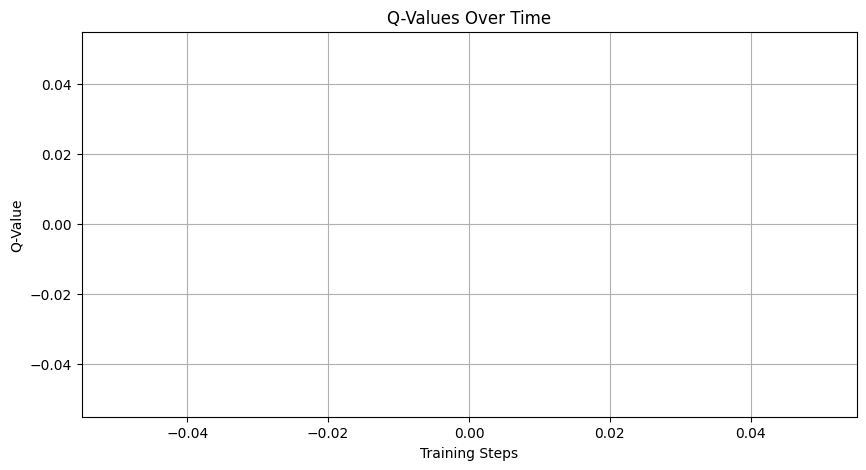

Episode: 1000, Steps: 5, eps: 0.630, reward = -27.25
Episode: 1100, Steps: 12, eps: 0.593, reward = -14.450000047683716
Episode: 1200, Steps: 21, eps: 0.556, reward = -35.50000008940697
Episode: 1300, Steps: 9, eps: 0.519, reward = -18.649999976158142
Episode: 1301, Steps: 10, eps: 0.518, reward = 53.04999861121178
Episode: 1400, Steps: 5, eps: 0.481, reward = -22.399999976158142
Episode: 1426, Steps: 21, eps: 0.472, reward = 56.04999849200249
Episode: 1455, Steps: 14, eps: 0.461, reward = 51.199998676776886
Episode: 1461, Steps: 15, eps: 0.459, reward = 52.04999861121178


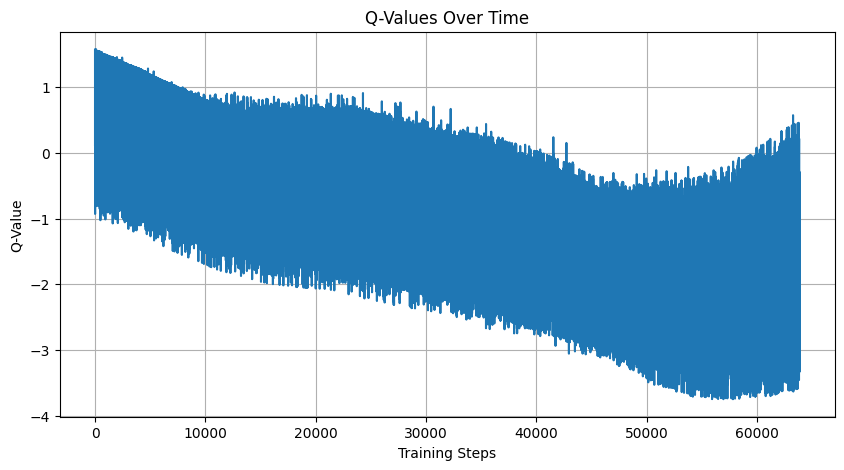

Episode: 1500, Steps: 15, eps: 0.444, reward = -21.749999821186066
Episode: 1544, Steps: 16, eps: 0.428, reward = 48.94999843835831
Episode: 1569, Steps: 25, eps: 0.419, reward = 28.599998325109482
Episode: 1591, Steps: 17, eps: 0.411, reward = 37.649998635053635
Episode: 1598, Steps: 15, eps: 0.408, reward = 51.29999852180481
Episode: 1600, Steps: 30, eps: 0.407, reward = -23.249999970197678
Episode: 1605, Steps: 16, eps: 0.406, reward = 51.14999857544899
Episode: 1676, Steps: 12, eps: 0.379, reward = 54.549998581409454
Episode: 1700, Steps: 14, eps: 0.370, reward = -19.349999964237213
Episode: 1706, Steps: 12, eps: 0.368, reward = 57.99999862909317
Episode: 1714, Steps: 14, eps: 0.365, reward = 56.34999838471413
Episode: 1719, Steps: 17, eps: 0.363, reward = 49.89999836683273
Episode: 1735, Steps: 17, eps: 0.357, reward = 53.64999842643738
Episode: 1761, Steps: 22, eps: 0.348, reward = 40.849998623132706
Episode: 1794, Steps: 18, eps: 0.336, reward = 52.199998408555984
Episode: 1800,

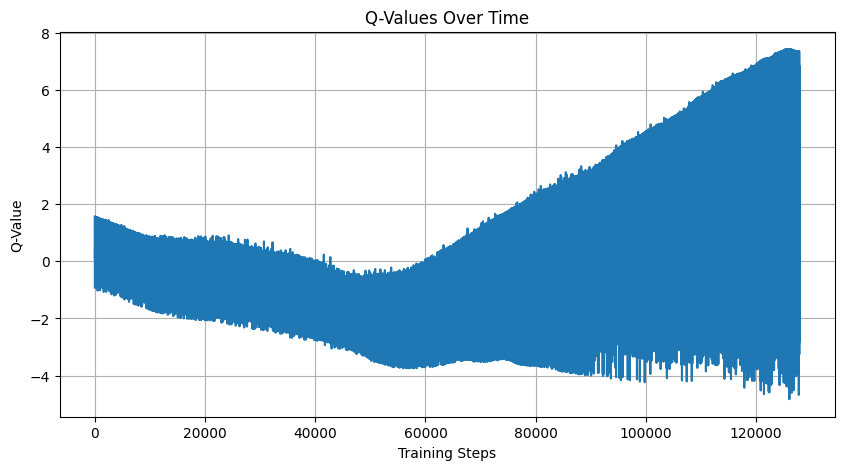

Episode: 2000, Steps: 8, eps: 0.259, reward = -7.149999976158142
Episode: 2065, Steps: 11, eps: 0.235, reward = 55.84999871253967
Episode: 2100, Steps: 41, eps: 0.222, reward = -20.5999998152256
Episode: 2149, Steps: 7, eps: 0.204, reward = 61.54999861121178
Episode: 2160, Steps: 11, eps: 0.200, reward = 54.4999985396862
Episode: 2161, Steps: 24, eps: 0.200, reward = 44.14999842643738
Episode: 2181, Steps: 14, eps: 0.192, reward = 57.59999856352806
Episode: 2200, Steps: 22, eps: 0.185, reward = -23.049999982118607
Episode: 2300, Steps: 11, eps: 0.148, reward = -12.499999701976776
Episode: 2344, Steps: 9, eps: 0.132, reward = 60.449998557567596
Episode: 2361, Steps: 15, eps: 0.126, reward = 59.099998474121094
Episode: 2377, Steps: 9, eps: 0.120, reward = 60.449998557567596
Episode: 2382, Steps: 9, eps: 0.118, reward = 60.449998557567596
Episode: 2385, Steps: 9, eps: 0.117, reward = 60.449998557567596
Episode: 2399, Steps: 14, eps: 0.111, reward = 55.14999860525131
Episode: 2400, Steps: 

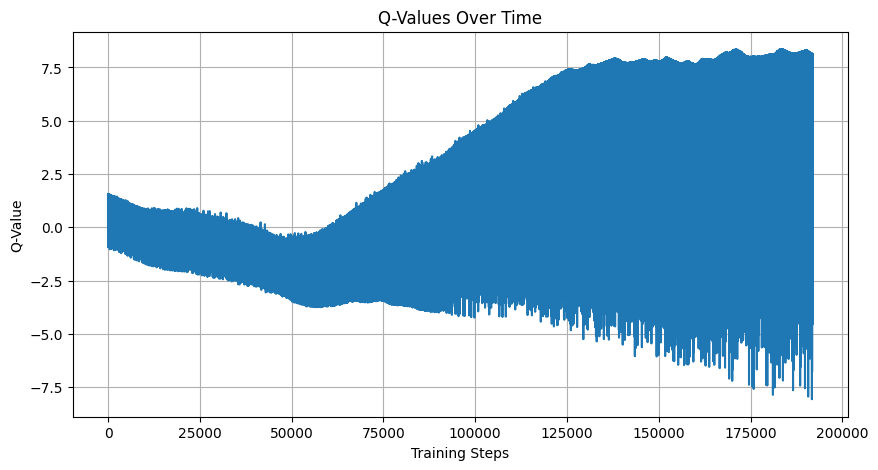

Episode: 2500, Steps: 13, eps: 0.074, reward = -16.69999986886978
Episode: 2531, Steps: 17, eps: 0.063, reward = 53.79999852180481
Episode: 2536, Steps: 16, eps: 0.061, reward = 56.79999852180481
Episode: 2546, Steps: 9, eps: 0.057, reward = 60.449998557567596
Episode: 2549, Steps: 18, eps: 0.056, reward = 50.44999837875366
Episode: 2554, Steps: 15, eps: 0.054, reward = 59.099998474121094
Episode: 2556, Steps: 15, eps: 0.053, reward = 59.099998474121094
Episode: 2559, Steps: 15, eps: 0.052, reward = 59.099998474121094
Episode: 2563, Steps: 14, eps: 0.051, reward = 56.449998527765274
Episode: 2566, Steps: 15, eps: 0.050, reward = 59.099998474121094
Episode: 2567, Steps: 15, eps: 0.049, reward = 59.349998474121094
Episode: 2568, Steps: 15, eps: 0.049, reward = 59.349998474121094
Episode: 2569, Steps: 16, eps: 0.049, reward = 55.49999859929085
Episode: 2570, Steps: 15, eps: 0.048, reward = 59.349998474121094
Episode: 2573, Steps: 16, eps: 0.047, reward = 56.79999852180481
Episode: 2574, S

KeyboardInterrupt: 

In [15]:
steps = 3000

# In the plotting function:
for episode in range(steps):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    if episode% 100 == 0 or cumilative_reward > 0:
        print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.get_weights()
        highest_reward = cumilative_reward

    if episode > 1000:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    

model.set_weights(best_weights)  # extra code – restores the best model weights

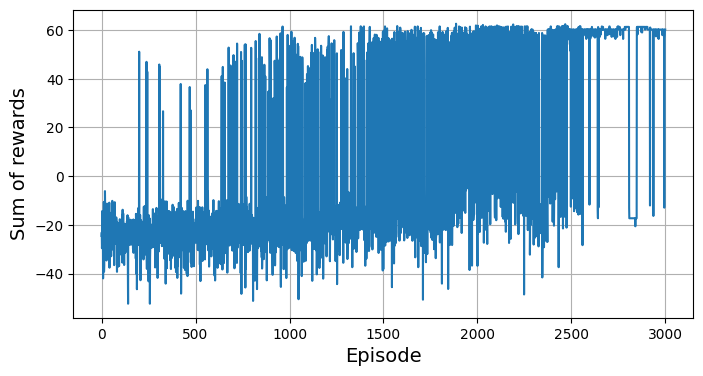

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

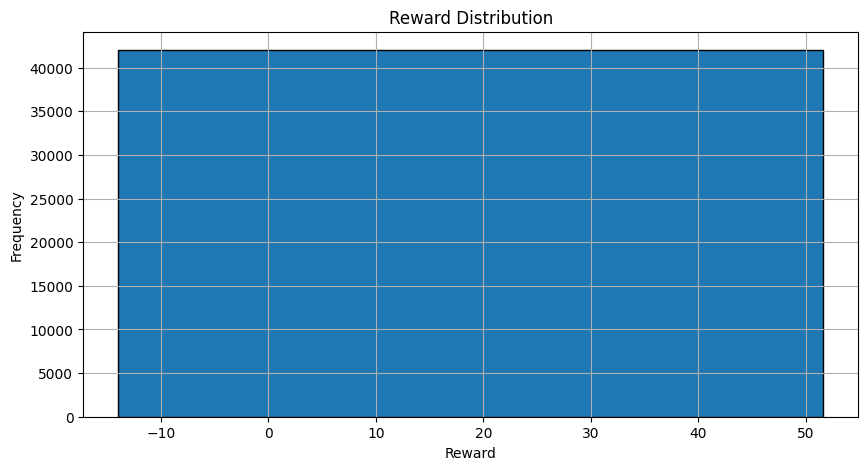

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()